# VinBigData Chest X-ray Abnormalities Detection using EfficientDet(Inference)

## Performance Comparison of Similar Models

<figure>
<img src="https://blog.roboflow.com/content/images/2020/06/yolov5-performance.png" style="width:700px">
</figure>

Check out the [EfficientDet Research Paper ](https://arxiv.org/pdf/1911.09070.pdf)  

## EfficientDet Structure
![image](https://aihub-storage.s3.ap-northeast-2.amazonaws.com/file/efficientdet.png)

### Import Libraries

In [1]:
!pip install timm==0.1.26

     |████████████████████████████████| 179 kB 865 kB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import sys
sys.path.insert(0, "../input/efficientdet-torch")
sys.path.insert(0, "../input/omegaconf")
sys.path.insert(0, "../input/weightedboxesfusion")
from ensemble_boxes import *
import torch
import os
import pydicom
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import Dataset,DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import gc
from matplotlib import pyplot as plt
from glob import glob
from effdet import get_efficientdet_config, EfficientDet, DetBenchEval
from effdet.efficientdet import HeadNet
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_valid_transforms():
    return A.Compose([
            A.Resize(height=1024, width=1024, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [4]:
image_dir = "../input/vinbigdata-chest-xray-abnormalities-detection/test"
class DatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms
        
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        dicom = pydicom.dcmread(f"{image_dir}/{image_id}.dicom")
        image = dicom.pixel_array
        if "PhotometricInterpretation" in dicom:
            if dicom.PhotometricInterpretation == "MONOCHROME1":
                image = np.amax(image) - image

        image = np.stack([image, image, image])
        image = image.astype('float32')
        image = image - image.min()
        image = image / image.max()
        image = image.transpose(1, 2, 0)
        
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [5]:
image_ids = glob(os.path.join('../input/vinbigdata-chest-xray-abnormalities-detection/test', "*.dicom"))
image_ids = [image_id.split('/')[-1].split('.')[0] for image_id in image_ids]
dataset = DatasetRetriever(image_ids = np.array(image_ids), transforms = get_valid_transforms())

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2, drop_last=False, collate_fn=collate_fn)

In [6]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

def load_net(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d4')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 14
    config.image_size = 1024
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])

    net = DetBenchEval(net, config)
    net.eval()
    return net.to(device)

net = load_net('../input/effdet-weights/last-checkpoint.bin')

In [7]:
def make_predictions(images, score_threshold=0.22):
    images = torch.stack(images).cuda().float()
    predictions = []
    with torch.no_grad():
        det = net(images, image_scales=torch.tensor([1] * images.shape[0]).float().cuda())
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:, :4]
            scores = det[i].detach().cpu().numpy()[:, 4]
            labels = det[i].detach().cpu().numpy()[:, 5]
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
                'labels': labels[indexes]
            })
    return [predictions]

def run_wbf(predictions, image_index, image_size=1024, iou_thr=0.5, skip_box_thr=0.4):
    boxes = [(prediction[image_index]['boxes'] / (image_size - 1)).tolist() for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist() for prediction in predictions]
    labels = [prediction[image_index]['labels'].tolist() for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr,
                                                  skip_box_thr=skip_box_thr)
    boxes = boxes * (image_size - 1)
    return boxes, scores, labels

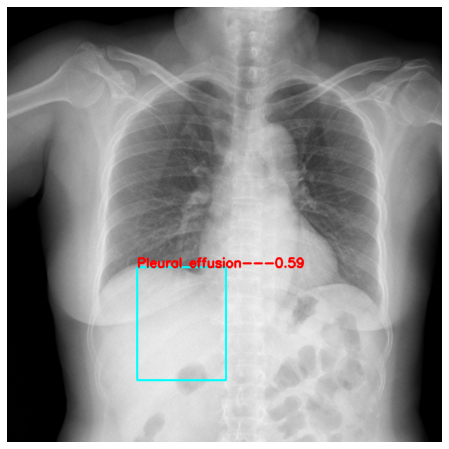

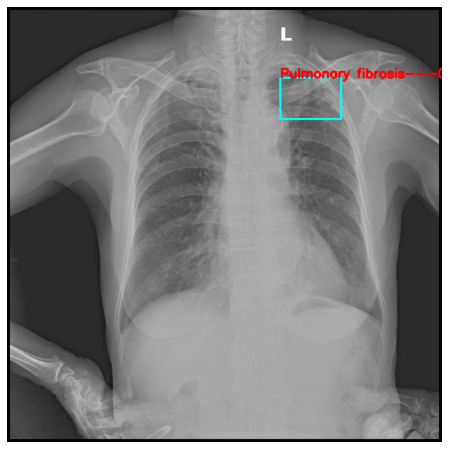

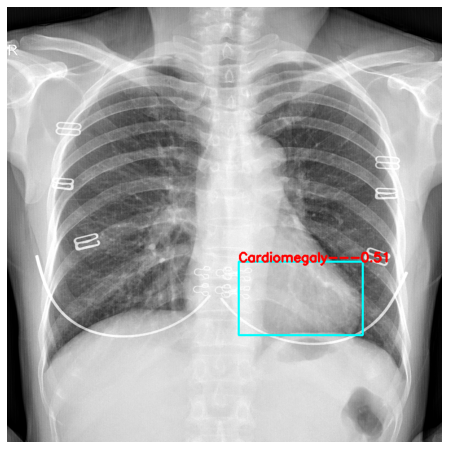

In [8]:
mapping = {0: 'Aortic enlargement', 1: 'Atelectasis', 2: 'Calcification', 3: 'Cardiomegaly', 4: 'Consolidation', 5: 'ILD',6: 'Infiltration', 7: 'Lung Opacity', 
           8: 'Nodule/Mass', 9: 'Other lesion', 10: 'Pleural effusion', 11: 'Pleural thickening',12: 'Pneumothorax', 13: 'Pulmonary fibrosis'}

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
thickness = 3
color = (1, 0, 0)
for j, (images, image_ids) in enumerate(data_loader):
    if j >= 20:
        break
    predictions = make_predictions(images=images, score_threshold=0.5)
    i = 1
    sample = images[i].permute(1, 2, 0).cpu().numpy()
    boxes, scores, labels = run_wbf(predictions, image_index=i)
    if len(labels) > 0:
        boxes = boxes.astype(np.int32).clip(min=0, max=1023)
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        for score, box, label in zip(scores, boxes, labels):
            cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (0, 1, 1), thickness)
            cv2.putText(sample, mapping[label] + "---" + str(round(score, 2)), (box[0], box[1]),
                        font, fontScale, color, thickness, cv2.LINE_AA)
        ax.set_axis_off()
        ax.imshow(sample)
        plt.show()

In [9]:
def format_prediction_string(boxes, scores, labels):
    pred_strings = []
    for pred in zip(labels, scores, boxes):
        pred_strings.append("{0} {1:.4f} {2} {3} {4} {5}".format(int(pred[0]), pred[1], pred[2][0], pred[2][1], pred[2][2], pred[2][3]))
    if len(pred_strings) == 0:
        return str("14 1 0 0 1 1")
    return " ".join(pred_strings)

In [10]:
results = []
from tqdm import tqdm
for images, image_ids in tqdm(data_loader):
    predictions = make_predictions(images)
    for i, image in enumerate(images):
        boxes, scores, labels = run_wbf(predictions, image_index=i)
        boxes = (boxes * 2).astype(np.int32).clip(min=0, max=1023)
        image_id = image_ids[i]

        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores, labels)
        }
        results.append(result)

100%|██████████| 375/375 [36:24<00:00,  5.82s/it]
